# Exp2: LightGBM With Almost no PP/FE 

In [1]:
# import packages
import gc
import os
import sys
import time
from contextlib import contextmanager
from pathlib import Path

import lightgbm as lgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import seaborn as sns
from IPython.core.display import HTML, display
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm_notebook as tqdm

PROJECT_DIR = "/app"
INPUT_FILE_PATH = Path("../..")
sys.path.insert(0, PROJECT_DIR)

# enable plotly offline plotting
plotly.offline.init_notebook_mode(connected=True)

# change figsize of seaborn
sns.set(rc={"figure.figsize": (8, 6)})

display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
# import modules
from src.logger.main import LOGGER, setup_logger
from src.preprocess.main import pp
from src.preprocess.read_file import read_file

In [4]:
# settings
EXP_ID = "exp2"
DATA_DIR = "../../input"
SEED = 42
LOGGER_PATH = "{}_log.txt".format(EXP_ID)
os.remove(LOGGER_PATH)
ID_COLUMNS = "id"
TARGET_COLUMNS = ["target"]
N_CLASSES = len(TARGET_COLUMNS)

fold_id = 1
OUTPUT_PATH = "{}_fold{}.pth".format(EXP_ID, fold_id)

setup_logger(out_file=LOGGER_PATH)
LOGGER.info("seed={}".format(SEED))

2019-10-28 00:15:48,307 - INFO - logger set up
2019-10-28 00:15:48,311 - INFO - seed=42


In [5]:
# timer set up 
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info('[{}] done in {} s'.format(name, round(time.time() - t0, 2)))

In [6]:
with timer('load data'):
    df, _ = read_file(DATA_DIR=DATA_DIR)
    y = df[TARGET_COLUMNS].values
    ids = df[[ID_COLUMNS]] 
    gc.collect()

2019-10-28 00:15:50,710 - INFO - [load data] done in 1.87 s


In [7]:
with timer('preprocessing'):
    df = pp(df)
    
    # fill NaN with most frequent values
    df.loc[:, 'direction'] = df['direction'].fillna(df['direction'].value_counts().index[0])
    df.loc[:, 'material'] = df['material'].fillna(df['material'].value_counts().index[0])
    df.loc[:, 'layout'] = df['layout'].fillna(df['direction'].value_counts().index[0])
    
    # One-Hot Encoding
    df = pd.concat([df, pd.get_dummies(df["direction"], prefix="ohe_direction")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["layout"], prefix="ohe_layout")], axis=1)
    df = pd.concat([df, pd.get_dummies(df["material"], prefix="ohe_material")], axis=1)

    # Drop unused columns
    df = df.drop(['id', 'layout', 'material', 'direction', 'neighbor'], axis=1)
    
    df.loc[:, 'target_log'] = np.log(df['target'])

2019-10-28 00:15:56,040 - INFO - [preprocessing] done in 5.29 s


In [8]:
# show correlation of one variable 
target_col_name = "target_log"
corr = df.corr()
index_sort_by_corr = (
    np.abs(corr.drop(["target", "target_log"])[target_col_name])
    .sort_values(ascending=False)
    .index
)

@interact(col_name=index_sort_by_corr)
def show_ohe_boxplot(col_name):
    sns.scatterplot(x=col_name, y=target_col_name, data=df).set_title(
        "corr_coef: {}".format(corr[col_name][target_col_name])
    )

interactive(children=(Dropdown(description='col_name', options=('area', 'ohe_bathroom_洗面台独立', 'ohe_kitchen_コンロ…

In [9]:
rename_cols = {}
i = 1
for col_name in df.filter(like="ohe_").columns:
    rename_cols[col_name] = "_".join(col_name.split('_')[:2]) + "_{}".format(i)
    i += 1
df = df.rename(columns=rename_cols) 

In [10]:
# LightGBM parameters
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 1000,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 20,
        'verbose' : 0
}

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:657: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.



[1]	valid_0's l2: 4.11762e+09
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 3.51597e+09
[3]	valid_0's l2: 3.01197e+09
[4]	valid_0's l2: 2.68145e+09
[5]	valid_0's l2: 2.33192e+09
[6]	valid_0's l2: 2.05219e+09
[7]	valid_0's l2: 1.82345e+09
[8]	valid_0's l2: 1.63881e+09
[9]	valid_0's l2: 1.49023e+09
[10]	valid_0's l2: 1.3653e+09
[11]	valid_0's l2: 1.2598e+09
[12]	valid_0's l2: 1.17305e+09
[13]	valid_0's l2: 1.11047e+09
[14]	valid_0's l2: 1.04953e+09
[15]	valid_0's l2: 9.99891e+08
[16]	valid_0's l2: 9.57272e+08
[17]	valid_0's l2: 9.25568e+08
[18]	valid_0's l2: 8.97772e+08
[19]	valid_0's l2: 8.76354e+08
[20]	valid_0's l2: 8.58284e+08
[21]	valid_0's l2: 8.3999e+08
[22]	valid_0's l2: 8.29219e+08
[23]	valid_0's l2: 8.16007e+08
[24]	valid_0's l2: 8.04164e+08
[25]	valid_0's l2: 8.01129e+08
[26]	valid_0's l2: 7.951e+08
[27]	valid_0's l2: 7.86401e+08
[28]	valid_0's l2: 7.84613e+08
[29]	valid_0's l2: 7.82359e+08
[30]	valid_0's l2: 7.79972e+08
[31]	valid_0's l2: 7.79

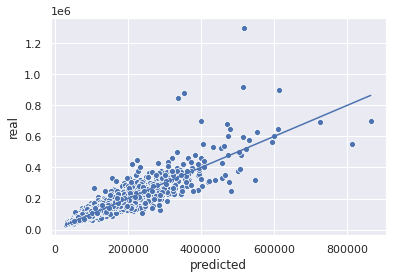

No.0 Score: 27100.03543659326
[1]	valid_0's l2: 4.845e+09
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 4.19241e+09
[3]	valid_0's l2: 3.65856e+09
[4]	valid_0's l2: 3.23316e+09
[5]	valid_0's l2: 2.86172e+09
[6]	valid_0's l2: 2.56492e+09
[7]	valid_0's l2: 2.32847e+09
[8]	valid_0's l2: 2.12943e+09
[9]	valid_0's l2: 1.95594e+09
[10]	valid_0's l2: 1.8093e+09
[11]	valid_0's l2: 1.68463e+09
[12]	valid_0's l2: 1.58045e+09
[13]	valid_0's l2: 1.49862e+09
[14]	valid_0's l2: 1.42602e+09
[15]	valid_0's l2: 1.37045e+09
[16]	valid_0's l2: 1.31927e+09
[17]	valid_0's l2: 1.2758e+09
[18]	valid_0's l2: 1.24579e+09
[19]	valid_0's l2: 1.21629e+09
[20]	valid_0's l2: 1.18682e+09
[21]	valid_0's l2: 1.14547e+09
[22]	valid_0's l2: 1.11336e+09
[23]	valid_0's l2: 1.0884e+09
[24]	valid_0's l2: 1.07361e+09
[25]	valid_0's l2: 1.05706e+09
[26]	valid_0's l2: 1.04413e+09
[27]	valid_0's l2: 1.03075e+09
[28]	valid_0's l2: 1.02063e+09
[29]	valid_0's l2: 1.00563e+09
[30]	valid_0's l2: 9.950

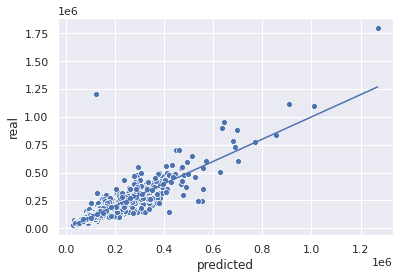

No.1 Score: 28212.557664700966
[1]	valid_0's l2: 4.29544e+09
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 3.68618e+09
[3]	valid_0's l2: 3.17111e+09
[4]	valid_0's l2: 2.7606e+09
[5]	valid_0's l2: 2.43129e+09
[6]	valid_0's l2: 2.16493e+09
[7]	valid_0's l2: 1.93886e+09
[8]	valid_0's l2: 1.76114e+09
[9]	valid_0's l2: 1.60615e+09
[10]	valid_0's l2: 1.48891e+09
[11]	valid_0's l2: 1.38545e+09
[12]	valid_0's l2: 1.30984e+09
[13]	valid_0's l2: 1.23886e+09
[14]	valid_0's l2: 1.18576e+09
[15]	valid_0's l2: 1.14887e+09
[16]	valid_0's l2: 1.11474e+09
[17]	valid_0's l2: 1.07914e+09
[18]	valid_0's l2: 1.05479e+09
[19]	valid_0's l2: 1.0359e+09
[20]	valid_0's l2: 1.01552e+09
[21]	valid_0's l2: 9.9515e+08
[22]	valid_0's l2: 9.711e+08
[23]	valid_0's l2: 9.4715e+08
[24]	valid_0's l2: 9.37156e+08
[25]	valid_0's l2: 9.21164e+08
[26]	valid_0's l2: 9.15361e+08
[27]	valid_0's l2: 9.02398e+08
[28]	valid_0's l2: 8.92999e+08
[29]	valid_0's l2: 8.88916e+08
[30]	valid_0's l2: 8.866

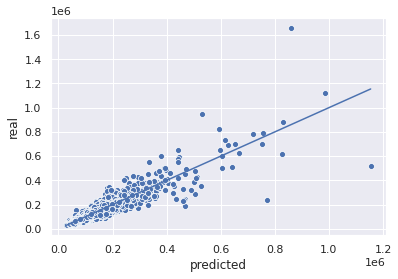

No.2 Score: 27826.444740058614
[1]	valid_0's l2: 4.95366e+09
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 4.25993e+09
[3]	valid_0's l2: 3.68861e+09
[4]	valid_0's l2: 3.23728e+09
[5]	valid_0's l2: 2.86023e+09
[6]	valid_0's l2: 2.56211e+09
[7]	valid_0's l2: 2.32423e+09
[8]	valid_0's l2: 2.10955e+09
[9]	valid_0's l2: 1.94024e+09
[10]	valid_0's l2: 1.7897e+09
[11]	valid_0's l2: 1.67626e+09
[12]	valid_0's l2: 1.57723e+09
[13]	valid_0's l2: 1.49022e+09
[14]	valid_0's l2: 1.41417e+09
[15]	valid_0's l2: 1.36055e+09
[16]	valid_0's l2: 1.30546e+09
[17]	valid_0's l2: 1.25927e+09
[18]	valid_0's l2: 1.22698e+09
[19]	valid_0's l2: 1.20265e+09
[20]	valid_0's l2: 1.17332e+09
[21]	valid_0's l2: 1.14759e+09
[22]	valid_0's l2: 1.12408e+09
[23]	valid_0's l2: 1.08883e+09
[24]	valid_0's l2: 1.07466e+09
[25]	valid_0's l2: 1.06043e+09
[26]	valid_0's l2: 1.03676e+09
[27]	valid_0's l2: 1.02016e+09
[28]	valid_0's l2: 1.00524e+09
[29]	valid_0's l2: 9.92147e+08
[30]	valid_0's l2: 

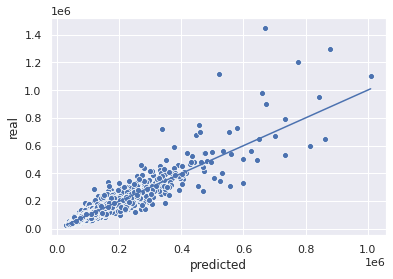

No.3 Score: 27292.093623862882
[1]	valid_0's l2: 5.06002e+09
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 4.40852e+09
[3]	valid_0's l2: 3.9069e+09
[4]	valid_0's l2: 3.57344e+09
[5]	valid_0's l2: 3.19451e+09
[6]	valid_0's l2: 2.8783e+09
[7]	valid_0's l2: 2.61633e+09
[8]	valid_0's l2: 2.41124e+09
[9]	valid_0's l2: 2.2286e+09
[10]	valid_0's l2: 2.08787e+09
[11]	valid_0's l2: 1.96026e+09
[12]	valid_0's l2: 1.86491e+09
[13]	valid_0's l2: 1.79834e+09
[14]	valid_0's l2: 1.71952e+09
[15]	valid_0's l2: 1.64835e+09
[16]	valid_0's l2: 1.58966e+09
[17]	valid_0's l2: 1.54199e+09
[18]	valid_0's l2: 1.49782e+09
[19]	valid_0's l2: 1.46082e+09
[20]	valid_0's l2: 1.42806e+09
[21]	valid_0's l2: 1.39509e+09
[22]	valid_0's l2: 1.37704e+09
[23]	valid_0's l2: 1.35278e+09
[24]	valid_0's l2: 1.33346e+09
[25]	valid_0's l2: 1.3169e+09
[26]	valid_0's l2: 1.30309e+09
[27]	valid_0's l2: 1.28986e+09
[28]	valid_0's l2: 1.27962e+09
[29]	valid_0's l2: 1.26493e+09
[30]	valid_0's l2: 1.2

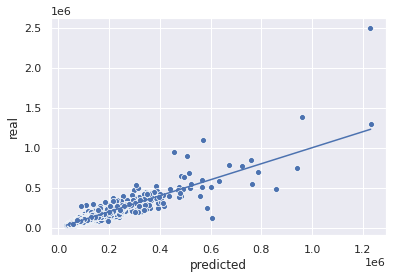

2019-10-28 00:19:10,023 - INFO - [Cross Validation] done in 186.41 s


No.4 Score: 30413.49553145231


In [11]:
with timer("Cross Validation"):
    scores = []
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED).split(df, y)
    for n_fold, (train_index, val_index) in enumerate(folds):
        train_df = df.loc[train_index]
        val_df = df.loc[val_index]
        y_train = y[train_index]
        y_val = y[val_index]

        lgb_train = lgb.Dataset(
            train_df.drop(["target", "target_log"], axis=1), y_train.flatten()
        )
        lgb_eval = lgb.Dataset(
            val_df.drop(["target", "target_log"], axis=1), y_val.flatten(), reference=lgb_train
        )

        gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=100,
            valid_sets=lgb_eval,
            early_stopping_rounds=10,
        )

        y_pred = gbm.predict(val_df.drop(["target", "target_log"], axis=1), num_iteration=gbm.best_iteration)

        # see the correlation between real and prediction
        ax = sns.scatterplot(x=y_pred.flatten(), y=y_val.flatten())
        ax = sns.lineplot(
            x=[y_pred.flatten().min(), y_pred.flatten().max()],
            y=[y_pred.flatten().min(), y_pred.flatten().max()],
        )
        ax.set(xlabel="predicted", ylabel="real")
        plt.show()

        score = np.sqrt(
            ((y_pred.flatten() - y_val.flatten()) ** 2).sum() / len(y_val.flatten())
        )
        scores.append(score)
        print("No.{} Score: {}".format(n_fold, score))

In [12]:
np.mean(scores)

28168.925399333606